**Big Data Project**

Giovincent Ricel's Tanoto - 2702226786

Nikolaus Marvin Liayasa - 2702233702

Ferlie Hernata - 2702231262

Josh Nicholas Sutanto - 2702234825

Rendy Riady - 2702234421

In [ ]:
# Digunakan untuk mempersiapkan empat  library sekaligus yaitu (Kaggle, pyspark, seaborn, dan matplotlib)
!pip install kaggle pyspark matplotlib seaborn

## Import Dependancies

In [ ]:
# Sistem & environment
import os                                                             # Mengakses fungsi-fungsi sistem operasi (misal cek file, atur path)
import warnings                                              # Modul untuk mengatur peringatan (warnings) di Python
warnings.filterwarnings('ignore')              # Menonaktifkan tampilnya warning agar output bersih

# Data handling & numerik
import numpy as np                                       # Array dan operasi matematika tingkat tinggi
import pandas as pd                                      # Struktur DataFrame untuk manipulasi dan analisis data

# Visualisasi
import matplotlib.pyplot as plt                # Plotting dasar (line, bar, scatter, histogram, dll.)
import seaborn as sns                                # Statistik plotting yang lebih tinggi (korelasi, distribusi, heatmap)

# Data retrieval dari Kaggle
from kagglehub import load_dataset, KaggleDatasetAdapter  # load_dataset: fungsi untuk mengambil dataset dari Kaggle
                                                                                                                        # KaggleDatasetAdapter.PANDAS: adapter agar hasilnya langsung DataFrame pandas

# Preprocessing & pipeline
from sklearn.impute import SimpleImputer                                                    # Mengisi nilai kosong (NaN) dengan strategi (median, mean, dll.)
from sklearn.pipeline import Pipeline                                                                # Menggabungkan beberapa langkah preprocessing + model jadi satu objek
from sklearn.compose import ColumnTransformer                                     # transform menjadi pipeline  numerik & kategorikal
from sklearn.preprocessing  import OneHotEncoder, StandardScaler   # encoder (Mengubah nilai kategorikal menjadi numerik) & scaler (digunakan  untuk mengstandarisasi numerik (mean = 0, var = 1))
from sklearn.utils import resample                                                                    # Untuk upsample manual dengan pandas


#Imbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Model
from sklearn.naive_bayes import GaussianNB
# GaussianNB: Naive Bayes dengan asumsi distribusi Gaussian untuk tiap fitur kontinu.
# Cepat dan ringan, cocok sebagai baseline untuk data berfitur numerik.

from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier: Ensemble dari banyak decision tree.
# - n_estimators: jumlah pohon dalam hutan.
# - max_depth: batas kedalaman tiap pohon untuk mencegah overfitting.
# - random_state: agar hasil eksperimen reproducible.

# Split & CV
from sklearn.model_selection import (
    train_test_split,                                                               # Membagi data jadi train set dan test set
    cross_val_score                                                              # Mengukur performa model dengan cross-validation
)

# Evaluasi
from sklearn.metrics        import (
    accuracy_score,                # akurasi prediksi
    classification_report,     # precision/recall/f1 per kelas
    confusion_matrix           # matriks 2×2 (untuk binary) yang menunjukkan TP, FP, FN, TN
)

## Import Dataset

In [ ]:
# Menggunakan API Dataset Kaggle
# Nama file di dalam dataset (lihat list files via CLI: `kaggle datasets files jillanisofttech/brain-stroke-dataset`)
file_path = "brain_stroke.csv"

# Muat ke pandas DataFrame
df = load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "jillanisofttech/brain-stroke-dataset",
  file_path
)

100%|██████████| 278k/278k [00:00<00:00, 1.29MB/s]


In [ ]:
# Menampilkan data untuk mengecek apakah sudah sesuai dengan dataset kaggle atau belum
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [ ]:
df.shape[0] # Melihat banyaknya row data

4981

In [ ]:
df.info() # Mengecek tipe data tiap column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [ ]:
df.isnull().sum() # Mengecek apakah terdapat missing value

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [ ]:
df.duplicated().sum() # Mengecek total duplicate

np.int64(0)

## Data Visualization

In [ ]:
df['stroke' ].value_counts() # Cek total pasien yang mengalami stroke dan tidak

,count
stroke,
0,4733
1,248


In [ ]:
# ============================================================================
# VISUALISASI DATA
#
# Sub‐bab:
# 1. Univariat – Variabel Kategorikal
# 2. Univariat – Variabel Kontinu (Age, BMI, Glucose)
# 3. Bivariat – Kategori vs. Stroke
# 4. Korelasi – Fitur Numerik
# 5. Imbalance – Distribusi Target (Stroke)
# ============================================================================

feature_cols_full = [
    'gender','age','hypertension','heart_disease',
    'ever_married','work_type','Residence_type',
    'avg_glucose_level','bmi','smoking_status','stroke'
]
data_df = df[feature_cols_full].copy()

num_cols = ['age','avg_glucose_level','bmi'] # numeric/kontinu fitur --> Cocok untuk countplot
cat_cols = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status'] # categorical feature

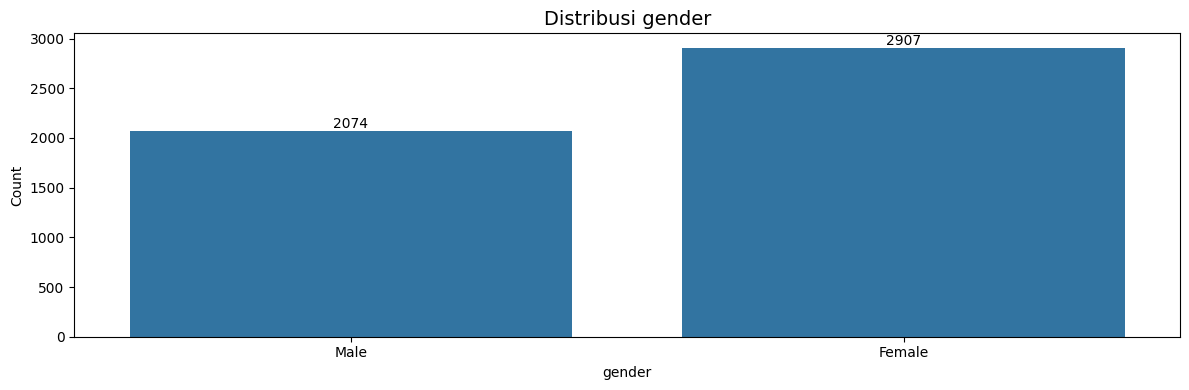

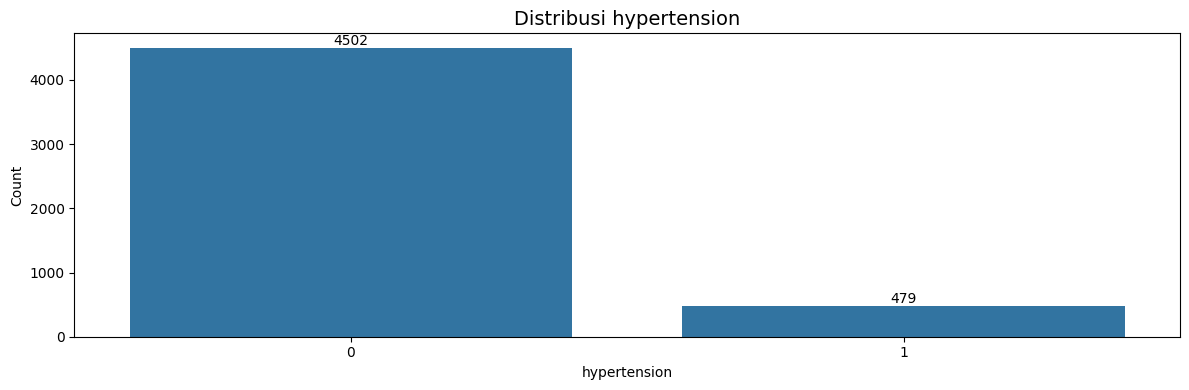

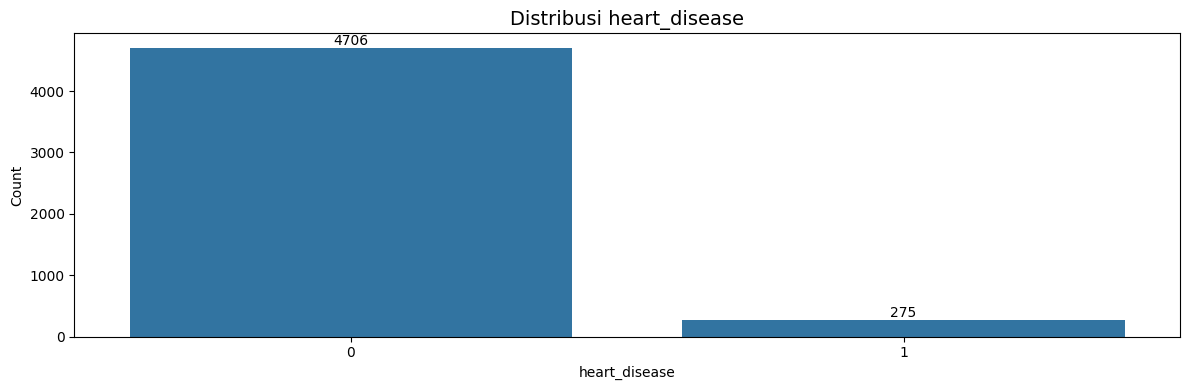

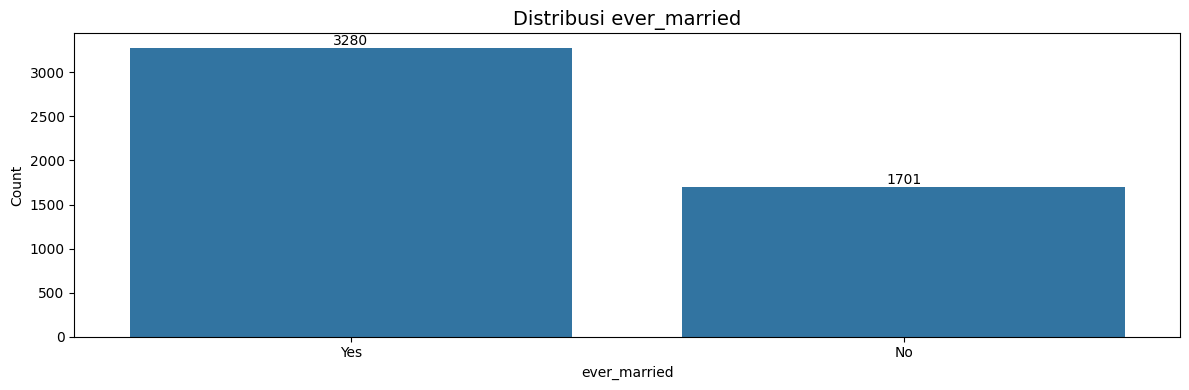

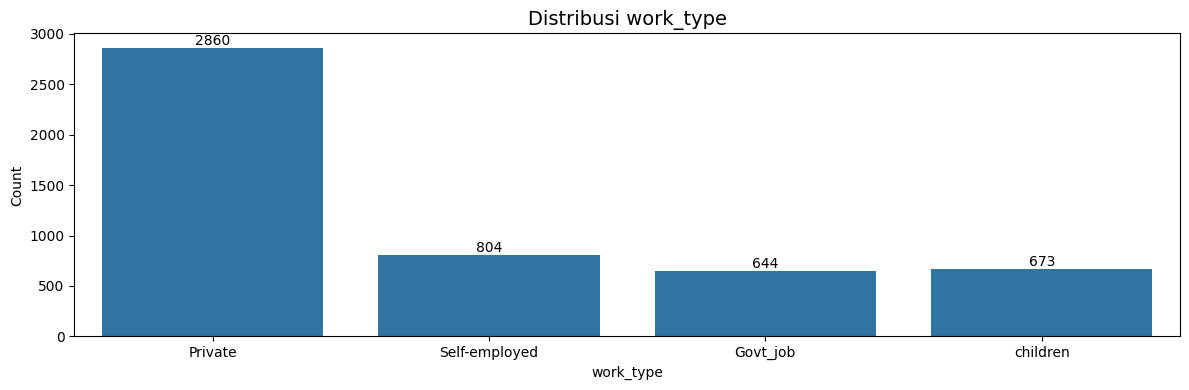

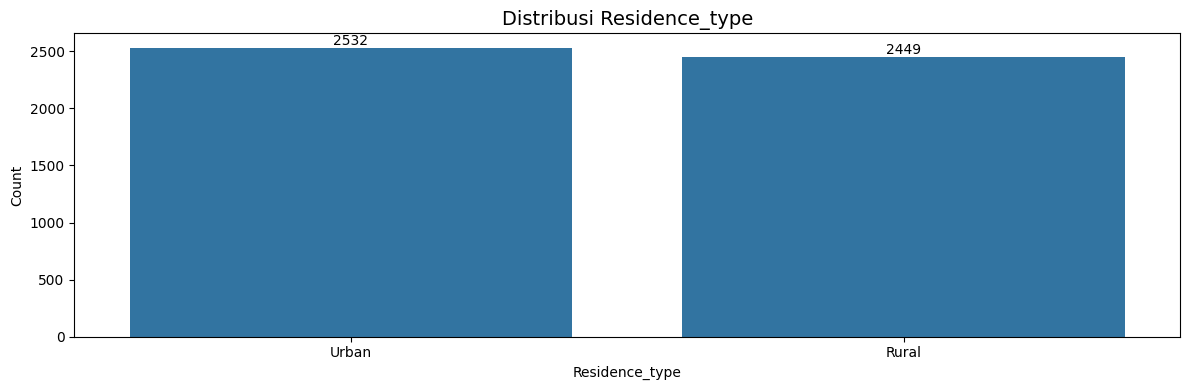

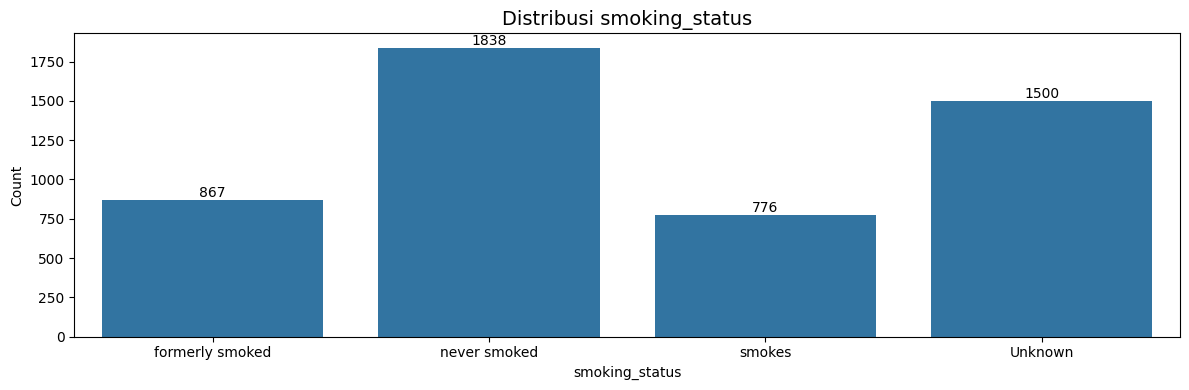

In [ ]:
# ----------------------------------------------------------------------------
# 1. Univariat – Variabel Kategorikal
#  Menampilkan countplot untuk tiap fitur kategorikal
# ----------------------------------------------------------------------------

for col in cat_cols:
    fig, ax = plt.subplots(figsize=(12,4))             # Buat figure baru dengan ukuran 12×4 inci
    ax = sns.countplot(data=data_df, x=col)    # Gambar countplot untuk kolom saat ini
    ax.bar_label(ax.containers[0])                       # Tambahkan label angka (count) di atas setiap bar
    plt.title(f"Distribusi {col}", fontsize=14)     # Set judul plot dengan nama kolom
    plt.xlabel(col)                                                      # Set label sumbu-X
    plt.ylabel("Count")                                             # Set label sumbu-Y
    plt.tight_layout()                                                # Rapikan layout agar elemen tidak terpotong
    plt.show()                                                             # Tampilkan plot


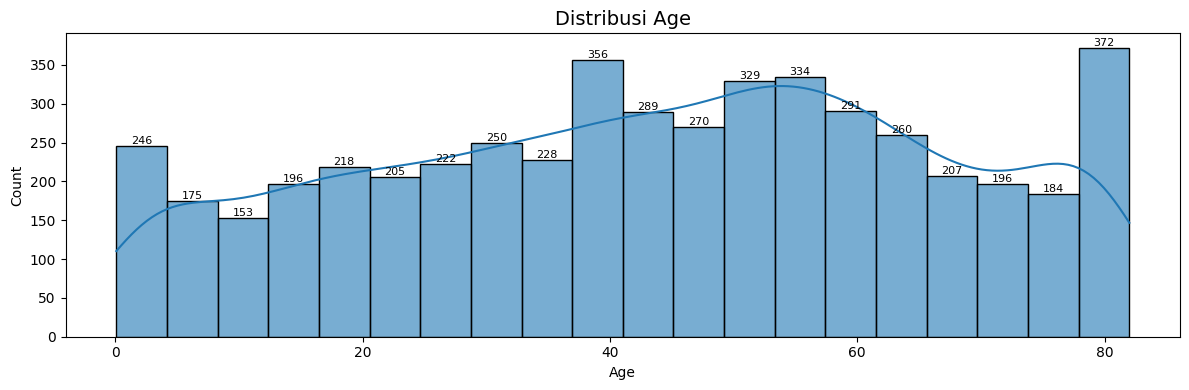

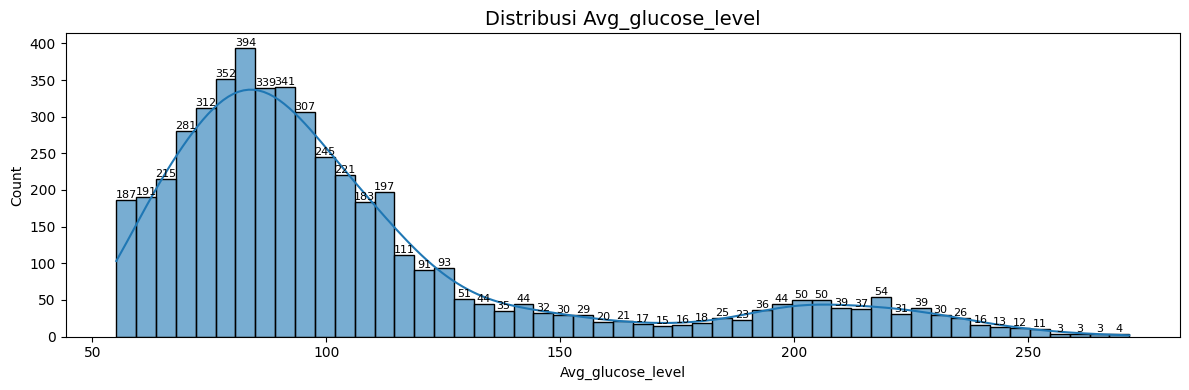

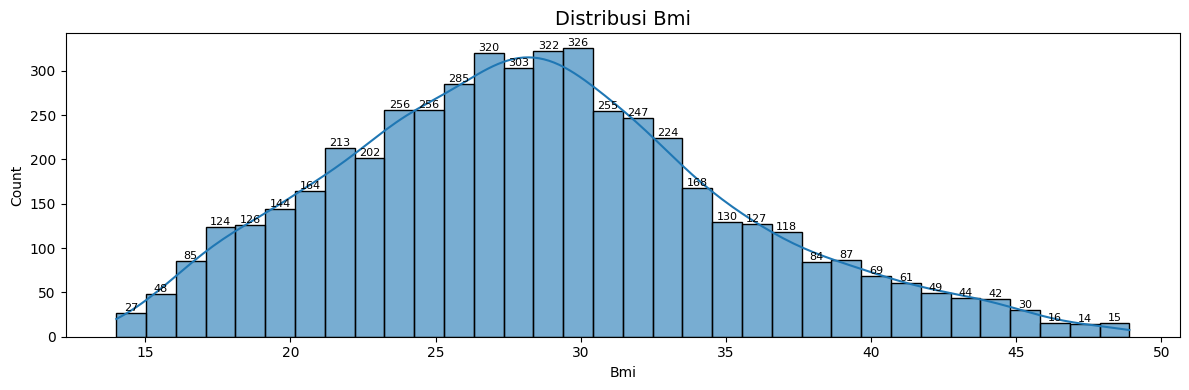

In [ ]:
# ----------------------------------------------------------------------------
# 2. Univariat – Variabel Kontinu
#  Histogram + KDE untuk Age, BMI, Avg Glucose Level
# ----------------------------------------------------------------------------

for col in num_cols:
    # Buat figure & axis
    fig, ax = plt.subplots(figsize=(12,4))

    # Gambar histogram + KDE, tapi histogram-nya hitung count
    sns.histplot(
    data_df[col],     # data yang akan diplot (array-like atau pandas Series)
    kde=True,         # jika True, tambahkan kurva KDE (kernel density estimate)
    stat='count',     # hitung jumlah sampel per bin (bisa juga 'frequency', 'density', dst.)
    edgecolor='k',    # warna garis pinggir setiap bar (di sini 'k' = black)
    alpha=0.6,        # transparansi bar (0 = transparan, 1 = solid)
    ax=ax,            # axes Matplotlib tempat plot ini digambar
    )

    # Tambahkan label angka count di atas setiap bar
    ax.bar_label(ax.containers[0], fontsize=8)

    # Hanya tampilkan grid horizontal
    ax.grid(False, axis='x')

    # Judul & label
    ax.set_title(f"Distribusi {col.capitalize()}", fontsize=14)
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel("Count")

    plt.tight_layout()
    plt.show()


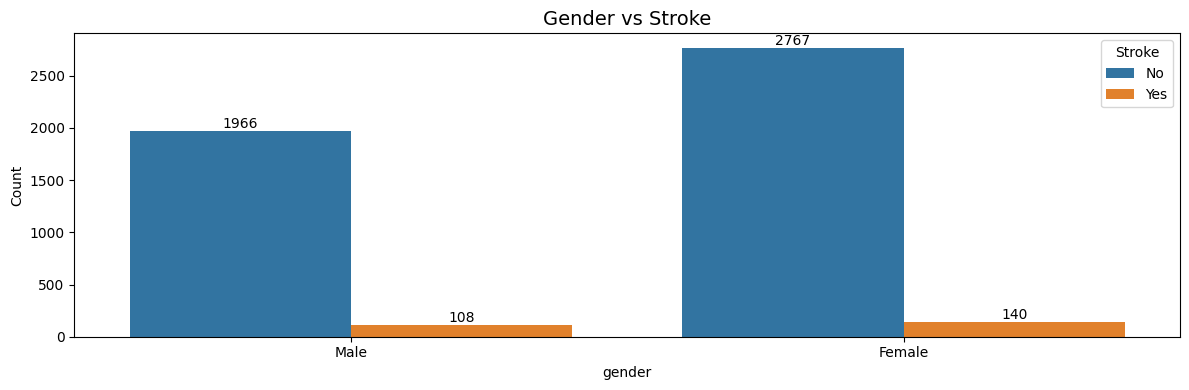

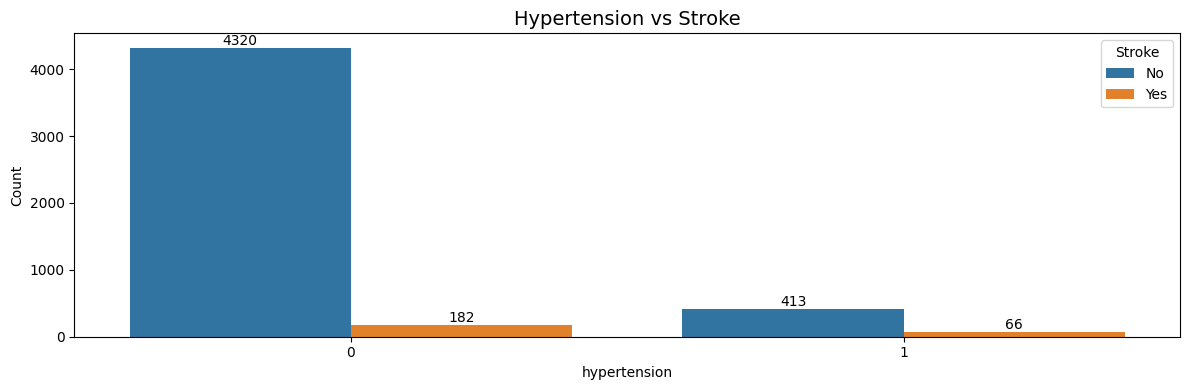

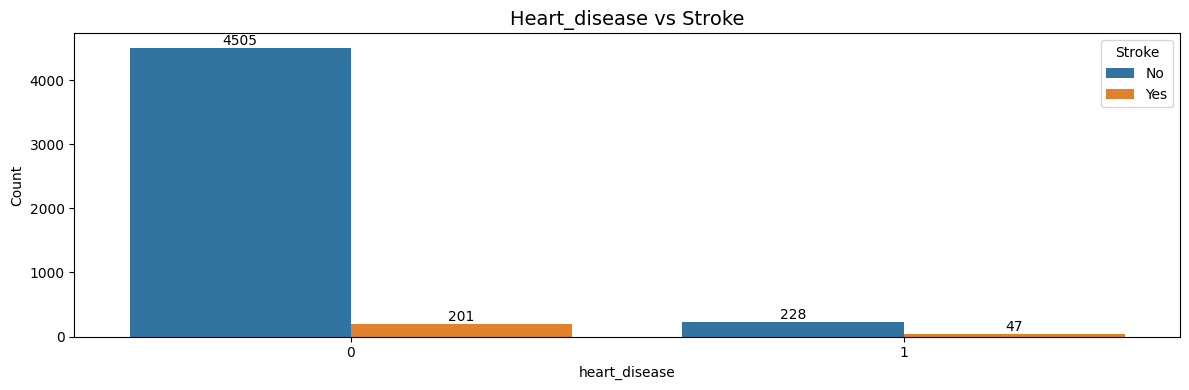

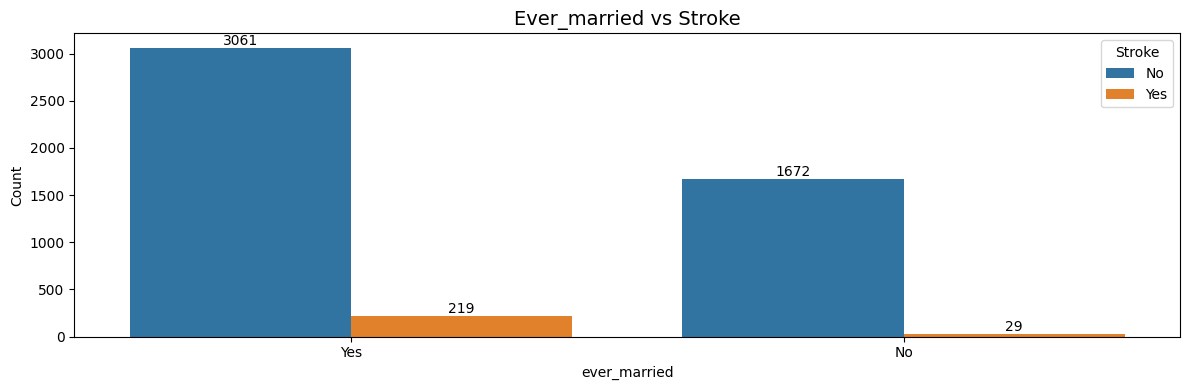

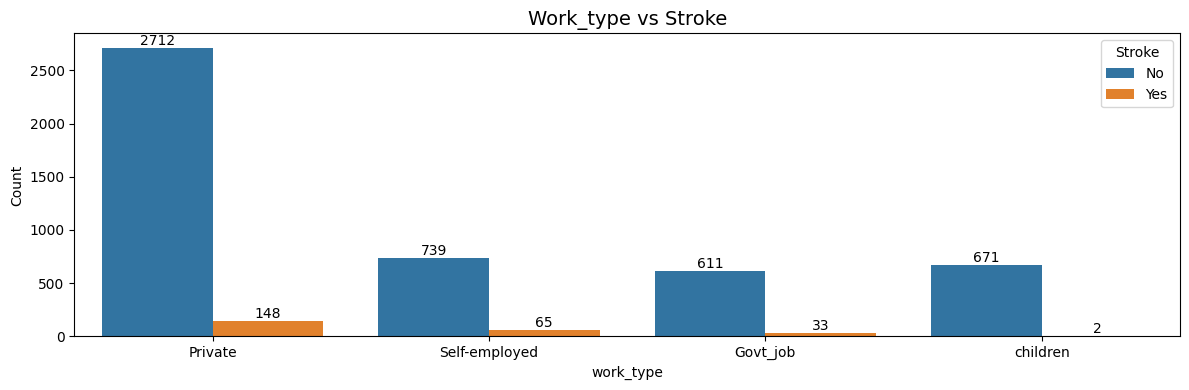

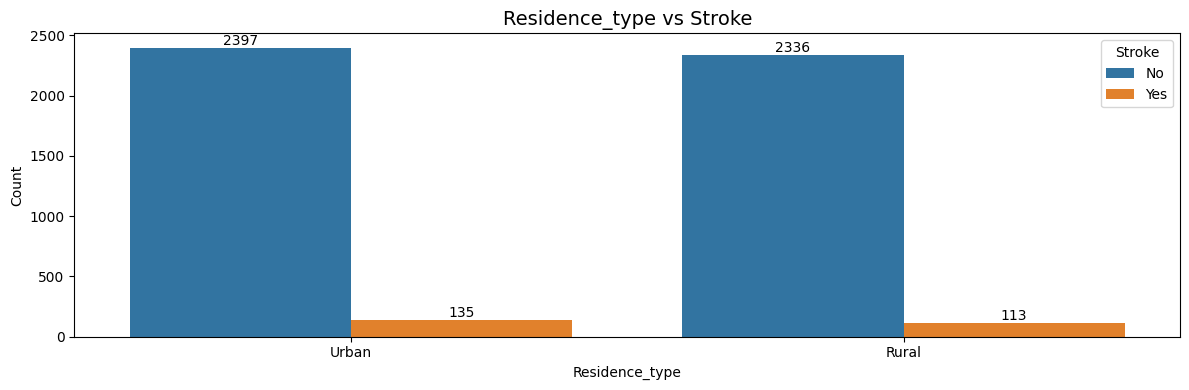

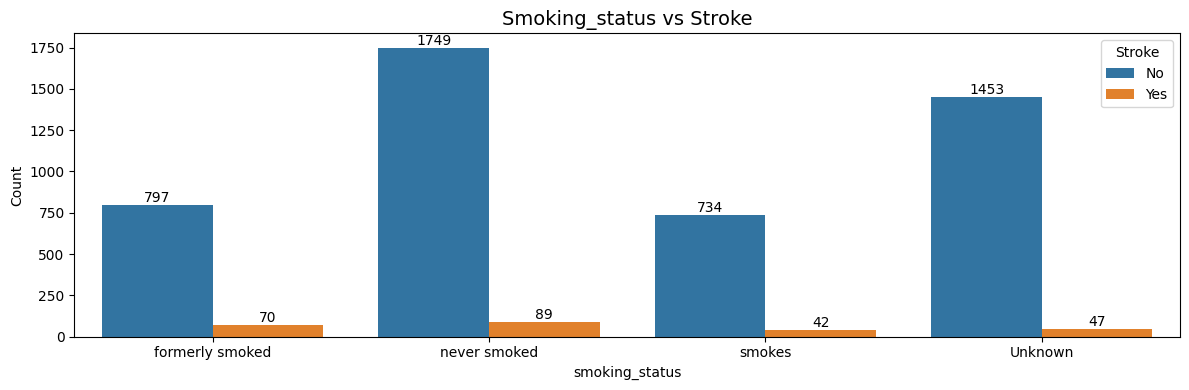

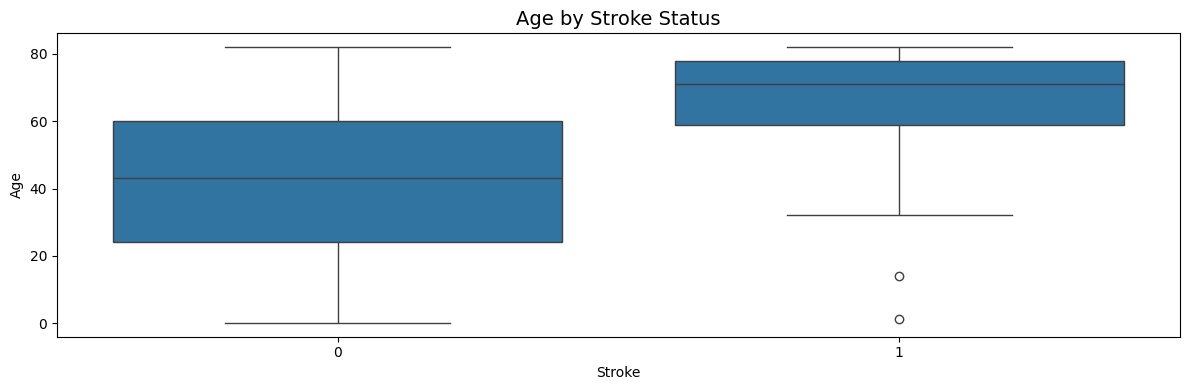

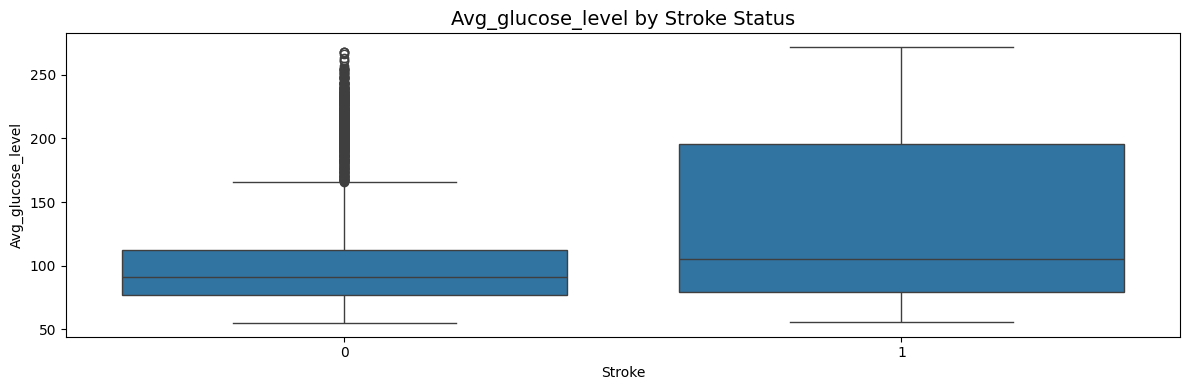

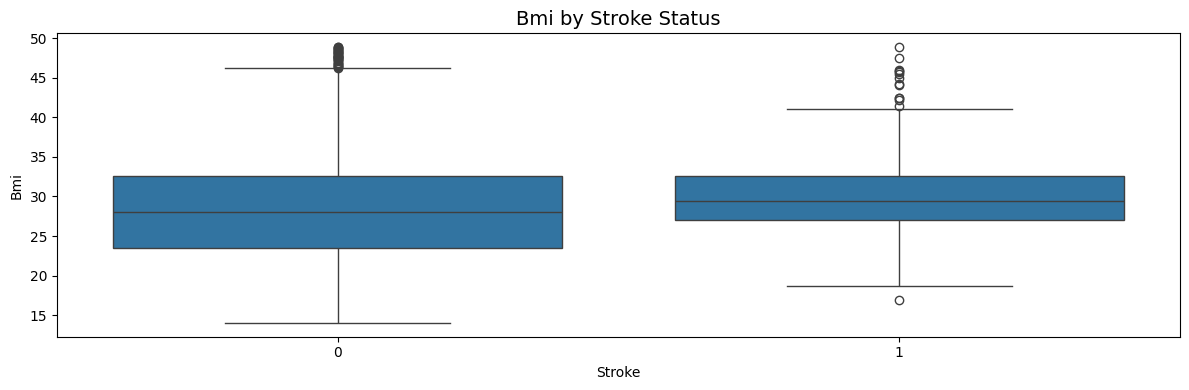

In [ ]:
# ----------------------------------------------------------------------------
# 3. Bivariat – Kategori vs. Stroke
#   Countplot dengan hue='stroke' untuk melihat per‐kelas
# ----------------------------------------------------------------------------

# Loop melalui setiap fitur kategorikal, tampilkan distribusi per‐kelas stroke beserta label count
for col in cat_cols:
    plt.figure(figsize=(12,4))
    ax = sns.countplot(data=data_df, x=col, hue='stroke')
    [ax.bar_label(c) for c in ax.containers] # tambahkan angka count di atas tiap bar
    plt.title(f"{col.capitalize()} vs Stroke", fontsize=14) # judul plot
    plt.xlabel(col)  # label sumbu-X
    plt.ylabel("Count")   # label sumbu-Y
    plt.legend(title='Stroke', labels=['No','Yes']) # keterangan hue stroke
    plt.tight_layout()   # rapikan layout
    plt.show()

# Boxplot / Violinplot untuk hubungan continuous vs stroke
for col in num_cols:
    plt.figure(figsize=(12,4))
    sns.boxplot(data=data_df, x='stroke', y=col)
    plt.title(f"{col.capitalize()} by Stroke Status", fontsize=14) # judul plot
    plt.xlabel("Stroke")  # label sumbu-X
    plt.ylabel(col.capitalize())  # label sumbu-Y
    plt.tight_layout() # rapikan layout
    plt.show()

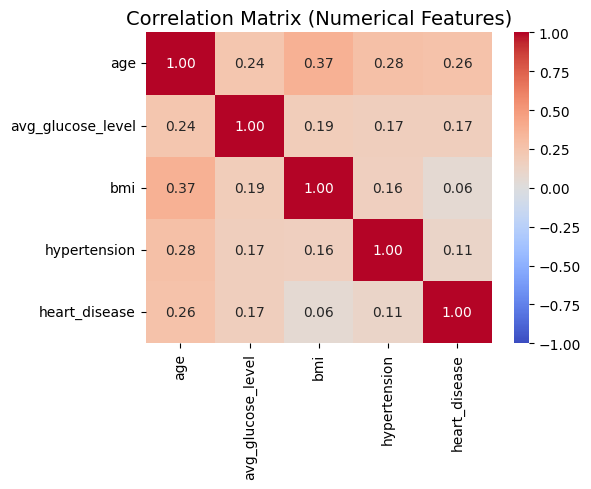

In [ ]:
# ----------------------------------------------------------------------------
# 4. Korelasi – Fitur Numerik
#   Heatmap korelasi antar fitur numerik
# ----------------------------------------------------------------------------
num_for_corr = ['age','avg_glucose_level','bmi','hypertension','heart_disease']
corr = data_df[num_for_corr].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix (Numerical Features)", fontsize=14)
plt.tight_layout()
plt.show()

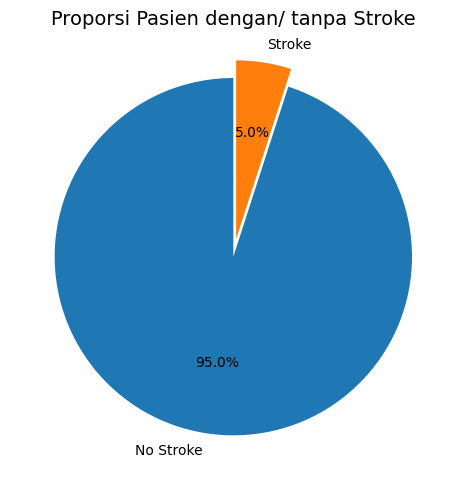

In [ ]:
# ----------------------------------------------------------------------------
# 5. Imbalance – Distribusi Target (Stroke)
#   Pie chart untuk menunjukkan proporsi kelas
# ----------------------------------------------------------------------------
counts = data_df['stroke'].value_counts()
labels = ['No Stroke','Stroke']

plt.figure(figsize=(5,5))
plt.pie(counts, labels=labels, autopct="%1.1f%%", startangle=90, explode=(0,0.1))
plt.title("Proporsi Pasien dengan/ tanpa Stroke", fontsize=14)
plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:
feature_cols = [
    'gender','age','hypertension','heart_disease',
    'ever_married','work_type','Residence_type',
    'avg_glucose_level','bmi','smoking_status'
]
X = df[feature_cols]    # hanya fitur
y = df['stroke']        # label/target

# Handling missing values
# Best practies buat jaga jaga

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # isi median jika ada NaN
    ('scaler',  StandardScaler()) # ubah dari mean ke var, mean = 0, std = 1
])

# Preprocessor ==> Menggabungkan langkah preprocessing numerik & kategorikal
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols), # Numerik, pipeline: imputasi median + standard scaler
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols) # Categorical, ubah kategorikal menjadi numerik
])

#Train/Test Modeling

In [ ]:
#Memisahkan data X dan y asli menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Terapkan praprosesor ke X_train dan X_test
# Pasangkan preprosesor hanya pada data pelatihan (X_train) untuk menghindari kebocoran data
X_train_processed = preprocessor.fit_transform(X_train)
# Transformasikan data uji menggunakan preprosesor yang dipasang pada data pelatihan
X_test_processed = preprocessor.transform(X_test)

# Oversampling dengan SMOTE (hanya di data train)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

In [ ]:
# Cek distribusi setelah SMOTE (optional)
from collections import Counter
print("Distribusi setelah SMOTE:", Counter(y_train_smote))

Distribusi setelah SMOTE: Counter({0: 3790, 1: 3790})


# Random Forest Classification

In [ ]:
# Buat model Random Forest dengan 20 pohon dan kriteria entropy
rand_clf = RandomForestClassifier(n_estimators=20, criterion="entropy", random_state=42)
# Latih model pakai data training yang sudah diproses
rand_clf.fit(X_train_smote, y_train_smote)

# Evaluasi di data uji (tanpa SMOTE)
# SMOTE hanya diterapkan pada data pelatihan agar model belajar dari distribusi seimbang, sedangkan evaluasi tetap
# menggunakan data uji asli tanpa SMOTE agar metrik mencerminkan performa nyata.
y_pred = rand_clf.predict(X_test_processed)

# Hitung dan cetak akurasi maupun classification report
print('Random Forest Classifier accuracy:', rand_clf.score(X_test_processed, y_test) * 100) # Score with processed data
print('Classification Report:', classification_report(y_test, y_pred))

Random Forest Classifier accuracy: 91.47442326980942
Classification Report:               precision    recall  f1-score   support

           0       0.95      0.97      0.96       943
           1       0.06      0.04      0.04        54

    accuracy                           0.91       997
   macro avg       0.50      0.50      0.50       997
weighted avg       0.90      0.91      0.91       997



# Naive-Bayes

In [ ]:
# Buat model Naive Bayes
NaiveBayes = GaussianNB()
# Latih model pakai data training yang sudah diproses (udah balance)
NaiveBayes.fit(X_train_smote, y_train_smote)

# Prediksi label untuk data uji yang sudah diproses
y_pred = NaiveBayes.predict(X_test_processed)

# Hitung dan cetak akurasi maupun klasifikasi datanya
print('The accuracy of Naive Bayes is:', accuracy_score(y_test, y_pred) * 100)
print('Classification Report:', classification_report(y_test, y_pred))

The accuracy of Naive Bayes is: 57.07121364092277
Classification Report:               precision    recall  f1-score   support

           0       0.99      0.55      0.71       943
           1       0.11      0.93      0.19        54

    accuracy                           0.57       997
   macro avg       0.55      0.74      0.45       997
weighted avg       0.94      0.57      0.68       997



# Model Accuracy comparison

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Dapatkan prediksi kedua model ---
y_pred_rf = rand_clf.predict(X_test_processed)
y_pred_nb = NaiveBayes.predict(X_test_processed)

# --- 2. Hitung metrik untuk masing-masing model ---
metrics = []
for name, y_pred in [("Random Forest", y_pred_rf),
                     ("Naive Bayes",    y_pred_nb)]:
    metrics.append({
        'Model':     name,
        'Accuracy':  accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Recall':    recall_score(y_test, y_pred, average='macro', zero_division=0),
        'F1 Score':  f1_score(y_test, y_pred, average='macro', zero_division=0)
    })

# --- 3. Buat DataFrame dan tampilkan ---
df_metrics = pd.DataFrame(metrics)
print(df_metrics.to_string(index=False))


        Model  Accuracy  Precision   Recall  F1 Score
Random Forest  0.914744   0.501544 0.501021  0.500162
  Naive Bayes  0.570712   0.548919 0.738149  0.448722


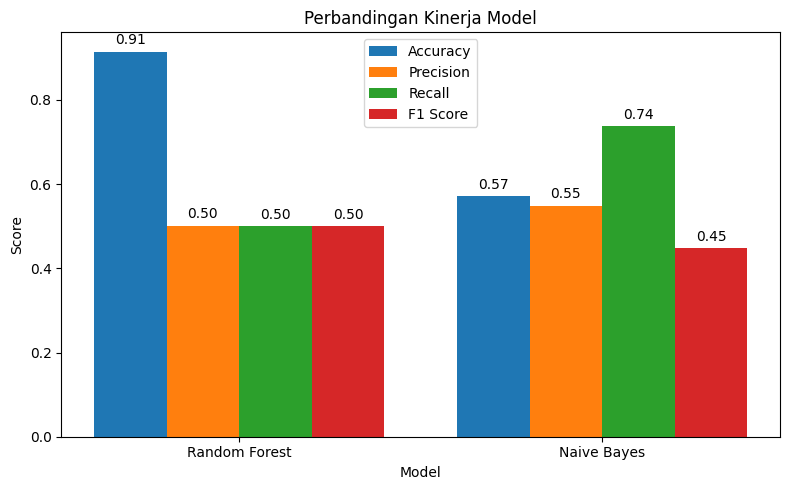

In [ ]:
import matplotlib.pyplot as plt

models = df_metrics['Model'].tolist()
scores = df_metrics[['Accuracy','Precision','Recall','F1 Score']]

x = list(range(len(models)))
width = 0.2

# Buat figure & axis
fig, ax = plt.subplots(figsize=(8, 5))

# Simpan objek bar untuk setiap metrik
bar_containers = []
for i, metric_name in enumerate(scores.columns):
    bars = ax.bar(
        [xi + i*width for xi in x],
        scores[metric_name],
        width=width,
        label=metric_name
    )
    bar_containers.append(bars)

# Tambahkan label nilai di atas bar (format 2 desimal)
for bars in bar_containers:
    ax.bar_label(bars, fmt='%.2f', padding=3)

# Atur label, judul, dan legenda
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Perbandingan Kinerja Model')
ax.set_xticks([xi + 1.5*width for xi in x])
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()
